In [ ]:
#Method 2
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
import os
import random

# Directories (New folder for Method 2)
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image_method2",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation_method2"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

pore_points = np.array([
    [50, 40], [48, 58], [47, 72], [45, 85], [44, 98], [46, 113],
    [58, 123], [54, 97], [60, 95], [85, 78], [88, 60]
])

def generate_pore_shape(scale=1.0):
    pts = pore_points * scale
    tck, _ = splprep(pts.T, s=0.5, per=True)
    u = np.linspace(0, 1.0, 300)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

def draw_pore_soft_mask(image, center, scale=0.4):
    h, w = image.shape[:2]
    shape = generate_pore_shape(scale)
    shape[:, 0] += center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += center[1] - shape[:, 1].mean().astype(int)

    # Create alpha mask
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [shape], 255)
    mask_blur = cv2.GaussianBlur(mask, (9, 9), 3)

    # Blend using alpha mask
    mask_blur_float = mask_blur.astype(float) / 255.0
    mask_blur_float = cv2.merge([mask_blur_float]*3)

    black_shape = np.zeros_like(image)
    blended = (mask_blur_float * black_shape + (1 - mask_blur_float) * image).astype(np.uint8)

    return blended, shape

def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue
    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = np.column_stack(np.where(mask == 255))
    if len(valid) == 0:
        continue

    cx, cy = random.choice(valid)
    image, pore_shape = draw_pore_soft_mask(image, (cy, cx))

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")



In [ ]:
#Method 3 improved (Best method and choosen)
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
import os
import random

# Directories
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image_method3_safe",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation_method3_safe"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# Pore control points
pore_points = np.array([
    [50, 40], [48, 58], [47, 72], [45, 85], [44, 98], [46, 113],
    [58, 123], [54, 97], [60, 95], [85, 78], [88, 60]
])

def generate_pore_shape(scale=1.0):
    pts = pore_points * scale
    tck, _ = splprep(pts.T, s=0.5, per=True)
    u = np.linspace(0, 1.0, 300)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

def draw_pore_supersample(image, center, scale=0.4, upscale=4):
    h, w = image.shape[:2]
    big_h, big_w = h * upscale, w * upscale
    big_canvas = cv2.resize(image, (big_w, big_h), interpolation=cv2.INTER_LINEAR)

    shape = generate_pore_shape(scale * upscale)
    shape[:, 0] += upscale * center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += upscale * center[1] - shape[:, 1].mean().astype(int)

    cv2.fillPoly(big_canvas, [shape], (0, 0, 0))
    result = cv2.resize(big_canvas, (w, h), interpolation=cv2.INTER_AREA)
    shape = (shape / upscale).astype(np.int32)

    return result, shape

def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

def get_safe_valid_points(mask, pore_shape_size=50, margin=5):
    # Remove unsafe margin from mask
    h, w = mask.shape
    safe_mask = np.zeros_like(mask)
    safe_mask[margin:h-margin, margin:w-margin] = mask[margin:h-margin, margin:w-margin]

    valid = np.column_stack(np.where(safe_mask == 255))
    return valid

for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = get_safe_valid_points(mask)
    if len(valid) == 0:
        print(f"⚠️ No safe ROI in {fname}")
        continue

    cx, cy = random.choice(valid)
    image, pore_shape = draw_pore_supersample(image, (cy, cx))

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with pore (Method 3 + ROI safety)")


✅ Saved 0c9c31fa-8-44.1.jpg with pore (Method 3 + ROI safety)


In [ ]:
#Method 1
import os
import cv2
import numpy as np
import random
from scipy.interpolate import splprep, splev

# Directories
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# Pore shape points (11 points example from your previous finalized shape)
pore_points = np.array([
    [50, 40], [48, 58], [47, 72], [45, 85], [44, 98], [46, 113],
    [58, 123], [54, 97], [60, 95], [85, 78], [88, 60]
])

# Generate smooth pore shape with anti-jagged method (supersampling)
def generate_pore_shape(scale=1.0):
    pts = pore_points * scale
    tck, _ = splprep(pts.T, s=0.5, per=True)
    u = np.linspace(0, 1.0, 300)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

# Draw pore safely inside image using mask check
def draw_pore_on_image_safely(image, mask, scale=0.4):
    h, w = image.shape[:2]
    eroded_mask = cv2.erode(mask, np.ones((10, 10), np.uint8), iterations=1)
    valid_points = np.column_stack(np.where(eroded_mask == 255))

    random.shuffle(valid_points)  # shuffle to avoid infinite loops
    for attempt, (cy, cx) in enumerate(valid_points):
        # Generate shape
        shape = generate_pore_shape(scale)
        shape[:, 0] += cx - shape[:, 0].mean().astype(int)
        shape[:, 1] += cy - shape[:, 1].mean().astype(int)

        # Create pore mask to check intersection
        temp_mask = np.zeros_like(mask)
        cv2.fillPoly(temp_mask, [shape], 255)
        intersection = cv2.bitwise_and(eroded_mask, temp_mask)

        if cv2.countNonZero(intersection) == cv2.countNonZero(temp_mask):
            # Valid pore found fully inside ROI
            # Supersampling approach to reduce jaggedness
            factor = 4
            upscale = cv2.resize(image, (w * factor, h * factor), interpolation=cv2.INTER_CUBIC)
            upscale_shape = (shape * factor).astype(np.int32)
            cv2.fillPoly(upscale, [upscale_shape], (0, 0, 0))
            downscale = cv2.resize(upscale, (w, h), interpolation=cv2.INTER_AREA)
            np.copyto(image, downscale)
            return shape
    print("⚠️ No valid placement found")
    return None

# Convert bbox to YOLO format
def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height  # class_id=2

# Main loop
for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue
    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        print(f"⚠️ Missing annotation for {fname}")
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    if np.count_nonzero(mask) == 0:
        print(f"⚠️ No valid Class 3 ROI in {fname}")
        continue

    pore_shape = draw_pore_on_image_safely(image, mask)
    if pore_shape is None:
        continue  # Skip if no safe placement found

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    out_img_path = os.path.join(dirs["output_images_dir"], fname)
    out_lbl_path = os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt"))
    cv2.imwrite(out_img_path, image)
    with open(out_lbl_path, 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with safe pore inside ROI")


✅ Saved 0c9c31fa-8-44.1.jpg with safe pore inside ROI


In [8]:
#Shape number 3 using Method 3 with ROI safety
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
import os
import random

# Directories
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# ---------------------- Custom Pore Control Points ----------------------
custom_pore_points = np.array([
    [110, 20], [85, 30], [65, 50], [55, 85], [65, 95],
    [100, 98], [110, 100], [155, 95], [165, 85], [155, 50],
    [135, 30], [110, 20]
], dtype=np.float32)

# Apply 20% movement for asymmetry
f = 0.20
custom_pore_points[5] = (1 - f) * custom_pore_points[5] + f * custom_pore_points[1]
custom_pore_points[6] = (1 - f) * custom_pore_points[6] + f * custom_pore_points[10]

def generate_custom_pore_shape(scale=1.0):
    pts = custom_pore_points * scale
    tck, _ = splprep(pts.T, s=0, per=True)
    u = np.linspace(0, 1.0, 500)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

def draw_pore_supersample(image, center, scale=0.4, upscale=4):
    h, w = image.shape[:2]
    big_h, big_w = h * upscale, w * upscale
    big_canvas = cv2.resize(image, (big_w, big_h), interpolation=cv2.INTER_LINEAR)

    shape = generate_custom_pore_shape(scale * upscale)
    shape[:, 0] += upscale * center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += upscale * center[1] - shape[:, 1].mean().astype(int)

    cv2.fillPoly(big_canvas, [shape], (0, 0, 0))
    result = cv2.resize(big_canvas, (w, h), interpolation=cv2.INTER_AREA)
    shape = (shape / upscale).astype(np.int32)

    return result, shape

def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

def get_safe_valid_points(mask, margin=5):
    h, w = mask.shape
    safe_mask = np.zeros_like(mask)
    safe_mask[margin:h-margin, margin:w-margin] = mask[margin:h-margin, margin:w-margin]
    valid = np.column_stack(np.where(safe_mask == 255))
    return valid

# ---------------------- Main Execution ----------------------
for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = get_safe_valid_points(mask)
    if len(valid) == 0:
        print(f"⚠️ No safe ROI in {fname}")
        continue

    cx, cy = random.choice(valid)
    image, pore_shape = draw_pore_supersample(image, (cy, cx))

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with custom pore (Method 3 + ROI safety)")



✅ Saved 0c9c31fa-8-44.1.jpg with custom pore (Method 3 + ROI safety)


In [ ]:
#Treid by failed
import cv2
import numpy as np
import os
import random
from scipy.interpolate import splprep, splev

# -------------------- Configuration --------------------
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# ---------------------- Custom Pore Shape ----------------------
custom_pore_points = np.array([
    [110, 20], [85, 30], [65, 50], [55, 85], [65, 95],
    [100, 98], [110, 100], [155, 95], [165, 85], [155, 50],
    [135, 30], [110, 20]
], dtype=np.float32)

f = 0.20
custom_pore_points[5] = (1 - f) * custom_pore_points[5] + f * custom_pore_points[1]
custom_pore_points[6] = (1 - f) * custom_pore_points[6] + f * custom_pore_points[10]

def generate_custom_pore_shape(scale=1.0):
    pts = custom_pore_points * scale
    tck, _ = splprep(pts.T, s=0, per=True)
    u = np.linspace(0, 1.0, 500)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

# ---------------------- Enhanced Draw ----------------------
def draw_pore_with_custom_shape_and_realistic_border(image, center, shape_points, upscale=4):
    h, w = image.shape[:2]
    up_h, up_w = h * upscale, w * upscale

    # Create large RGBA canvas
    big_canvas = np.zeros((up_h, up_w, 4), dtype=np.uint8)

    # Scale and position the custom pore shape
    shape = shape_points * upscale
    shape[:, 0] += upscale * center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += upscale * center[1] - shape[:, 1].mean().astype(int)
    shape = shape.astype(np.int32)

    # --- 1. Fill Core ---
    cv2.fillPoly(big_canvas, [shape], (45, 45, 45, 255), lineType=cv2.LINE_AA)

    # --- 2. Outer Ring using fading polylines ---
    fade_segments = 6
    for i in range(fade_segments):
        opacity = int(np.interp(i, [0, fade_segments - 1], [180, 30]))
        thickness = int(np.interp(i, [0, fade_segments - 1], [int(3 * upscale), int(1 * upscale)]))
        color = (180, 180, 180, opacity)
        cv2.polylines(big_canvas, [shape], isClosed=True, color=color, thickness=thickness, lineType=cv2.LINE_AA)

    # --- 3. Apply Gaussian blur only on alpha ---
    big_canvas[:, :, 3] = cv2.GaussianBlur(big_canvas[:, :, 3], (5, 5), sigmaX=2.0)

    # --- 4. Downscale back safely ---
    final = cv2.resize(big_canvas, (w, h), interpolation=cv2.INTER_AREA)

    # --- 5. Blend with the original image using alpha ---
    alpha = final[..., 3] / 255.0
    for c in range(3):
        image[..., c] = (alpha * final[..., c] + (1 - alpha) * image[..., c]).astype(np.uint8)

    shape_rescaled = (shape / upscale).astype(np.int32)
    return image, shape_rescaled

# ---------------------- Helper Functions ----------------------
def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

def get_safe_valid_points(mask, margin=5):
    h, w = mask.shape
    safe_mask = np.zeros_like(mask)
    safe_mask[margin:h-margin, margin:w-margin] = mask[margin:h-margin, margin:w-margin]
    valid = np.column_stack(np.where(safe_mask == 255))
    return valid

# ---------------------- Main Execution ----------------------
for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = get_safe_valid_points(mask)
    if len(valid) == 0:
        print(f"⚠️ No safe ROI in {fname}")
        continue

    cx, cy = random.choice(valid)
    shape_points = generate_custom_pore_shape(scale=0.4)
    image, pore_shape = draw_pore_with_custom_shape_and_realistic_border(image, (cy, cx), shape_points)

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with custom pore shape and realistic border")


✅ Saved 0c9c31fa-8-44.1.jpg with custom pore shape and realistic border


In [ ]:
#latest script
import cv2
import numpy as np
import os
import random
from scipy.interpolate import splprep, splev

# -------------------- Configuration --------------------
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# ---------------------- Custom Pore Shape ----------------------
custom_pore_points = np.array([
    [110, 20], [85, 30], [65, 50], [55, 85], [65, 95],
    [100, 98], [110, 100], [155, 95], [165, 85], [155, 50],
    [135, 30], [110, 20]
], dtype=np.float32)

f = 0.20
custom_pore_points[5] = (1 - f) * custom_pore_points[5] + f * custom_pore_points[1]
custom_pore_points[6] = (1 - f) * custom_pore_points[6] + f * custom_pore_points[10]

def generate_custom_pore_shape(scale=1.0):
    pts = custom_pore_points * scale
    tck, _ = splprep(pts.T, s=0, per=True)
    u = np.linspace(0, 1.0, 500)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

# ---------------------- Outer Ring Rules for Custom Shape ----------------------
def draw_faded_arcs_on_contour(canvas, contour, segments=6, upscale=4):
    perimeter = cv2.arcLength(contour, True)
    points_len = len(contour)

    for i in range(segments):
        start_fraction = random.uniform(0, 1)
        arc_length = random.uniform(0.2, 0.3) * perimeter
        end_fraction = start_fraction + arc_length / perimeter

        # Convert to point indices
        start_idx = int(start_fraction * points_len)
        end_idx = int(end_fraction * points_len)

        if end_idx > points_len:
            arc_segment = np.concatenate((contour[start_idx:], contour[:end_idx - points_len]))
        else:
            arc_segment = contour[start_idx:end_idx]

        if len(arc_segment) < 2:
            continue

        fade_layers = 6
        for j in range(fade_layers):
            opacity = int(np.interp(j, [0, fade_layers - 1], [180, 30]))
            thickness = int(np.interp(j, [0, fade_layers - 1], [int(3 * upscale), int(1 * upscale)]))
            color = (180, 180, 180, opacity)
            cv2.polylines(canvas, [arc_segment], False, color, thickness=thickness, lineType=cv2.LINE_AA)

# ---------------------- Complete Draw Function ----------------------
def draw_pore_with_custom_shape_and_script2_ring(image, center, shape_points, upscale=4):
    h, w = image.shape[:2]
    up_h, up_w = h * upscale, w * upscale
    big_canvas = np.zeros((up_h, up_w, 4), dtype=np.uint8)

    shape = shape_points * upscale
    shape[:, 0] += upscale * center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += upscale * center[1] - shape[:, 1].mean().astype(int)
    shape = shape.astype(np.int32)

    cv2.fillPoly(big_canvas, [shape], (45, 45, 45, 255), lineType=cv2.LINE_AA)

    draw_faded_arcs_on_contour(big_canvas, shape, segments=6, upscale=upscale)

    big_canvas[:, :, 3] = cv2.GaussianBlur(big_canvas[:, :, 3], (5, 5), sigmaX=2.0)

    final = cv2.resize(big_canvas, (w, h), interpolation=cv2.INTER_AREA)
    alpha = final[..., 3] / 255.0
    for c in range(3):
        image[..., c] = (alpha * final[..., c] + (1 - alpha) * image[..., c]).astype(np.uint8)

    shape_rescaled = (shape / upscale).astype(np.int32)
    return image, shape_rescaled

# ---------------------- Helper Functions ----------------------
def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

def get_safe_valid_points(mask, margin=5):
    h, w = mask.shape
    safe_mask = np.zeros_like(mask)
    safe_mask[margin:h-margin, margin:w-margin] = mask[margin:h-margin, margin:w-margin]
    valid = np.column_stack(np.where(safe_mask == 255))
    return valid

# ---------------------- Main Execution ----------------------
for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = get_safe_valid_points(mask)
    if len(valid) == 0:
        print(f"⚠️ No safe ROI in {fname}")
        continue

    cx, cy = random.choice(valid)
    shape_points = generate_custom_pore_shape(scale=0.4)
    image, pore_shape = draw_pore_with_custom_shape_and_script2_ring(image, (cy, cx), shape_points)

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with custom pore shape and realistic broken outer ring")

✅ Saved 0c9c31fa-8-44.1.jpg with custom pore shape and realistic broken outer ring


In [4]:
import cv2
import numpy as np
import os
import random
from scipy.interpolate import splprep, splev

# -------------------- Configuration --------------------
dirs = {
    "image_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/images",
    "annotation_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/yolov8",
    "output_images_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/image",
    "output_labels_dir": "F:/Pomodoro/Work/TIME/Script/Thesis-Abbas-Segmentation/PolygontoYOLO/ErrorPlayground/pore_dataset/annotation"
}

os.makedirs(dirs["output_images_dir"], exist_ok=True)
os.makedirs(dirs["output_labels_dir"], exist_ok=True)

# ---------------------- Pore Shape ----------------------
custom_pore_points = np.array([
    [110, 20], [85, 30], [65, 50], [55, 85], [65, 95],
    [100, 98], [110, 100], [155, 95], [165, 85], [155, 50],
    [135, 30], [110, 20]
], dtype=np.float32)
f = 0.20
custom_pore_points[5] = (1 - f) * custom_pore_points[5] + f * custom_pore_points[1]
custom_pore_points[6] = (1 - f) * custom_pore_points[6] + f * custom_pore_points[10]

def generate_custom_pore_shape(scale=1.0):
    pts = custom_pore_points * scale
    tck, _ = splprep(pts.T, s=0, per=True)
    u = np.linspace(0, 1.0, 500)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

# ---------------------- Drawing Function ----------------------
def draw_pore_strategy3_distance_glow(image, shape_points, center, upscale=1):
    h, w = image.shape[:2]
    shape = shape_points * upscale
    shape[:, 0] += center[0] - shape[:, 0].mean().astype(int)
    shape[:, 1] += center[1] - shape[:, 1].mean().astype(int)
    shape = shape.astype(np.int32)

    canvas = np.zeros((h, w, 4), dtype=np.uint8)

    # Initial fill for dark core (this will be re-filled after glow too)
    cv2.fillPoly(canvas, [shape], (30, 30, 30, 255), lineType=cv2.LINE_AA)

    # Distance-based glow (only outside the shape)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [shape], 255)
    dist = cv2.distanceTransform(255 - mask, distanceType=cv2.DIST_L2, maskSize=5)
    dist = np.clip(dist, 0, 25)
    glow_alpha = (1 - dist / 25) * 200
    glow_alpha = glow_alpha.astype(np.uint8)
    glow_alpha[mask == 255] = 0  # Exclude glow from core

    glow_layer = np.zeros((h, w, 4), dtype=np.uint8)
    for i in range(3):
        glow_layer[..., i] = 220
    glow_layer[..., 3] = glow_alpha

    alpha = glow_layer[..., 3] / 255.0
    for c in range(3):
        canvas[..., c] = (alpha * glow_layer[..., c] + (1 - alpha) * canvas[..., c]).astype(np.uint8)

    # Redraw the core on top to reinforce darkness
    cv2.fillPoly(canvas, [shape], (30, 30, 30, 255), lineType=cv2.LINE_AA)

    # Add arc details for depth
    for i in range(3):
        start_idx = int(len(shape) * 0.3) + i * 20
        end_idx = start_idx + 30
        arc = shape[start_idx:end_idx]
        opacity = int(np.interp(i, [0, 2], [80, 30]))
        thickness = int(np.interp(i, [0, 2], [4, 1]))
        cv2.polylines(canvas, [arc], False, (180, 180, 180, opacity), thickness=thickness, lineType=cv2.LINE_AA)

    # Final alpha blending
    alpha_final = canvas[..., 3] / 255.0
    for c in range(3):
        image[..., c] = (alpha_final * canvas[..., c] + (1 - alpha_final) * image[..., c]).astype(np.uint8)

    return image, shape

# ---------------------- Helpers ----------------------
def to_yolo_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return 2, x_center, y_center, width, height

def get_safe_valid_points(mask, margin=5):
    h, w = mask.shape
    safe_mask = np.zeros_like(mask)
    safe_mask[margin:h-margin, margin:w-margin] = mask[margin:h-margin, margin:w-margin]
    valid = np.column_stack(np.where(safe_mask == 255))
    return valid

# ---------------------- Main Execution ----------------------
for fname in os.listdir(dirs["image_dir"]):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(dirs["image_dir"], fname)
    ann_path = os.path.join(dirs["annotation_dir"], fname.replace(".jpg", ".txt"))
    if not os.path.exists(ann_path):
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) != 3:
                continue
            coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 255)

    valid = get_safe_valid_points(mask)
    if len(valid) == 0:
        print(f"⚠️ No safe ROI in {fname}")
        continue

    cx, cy = random.choice(valid)
    shape_points = generate_custom_pore_shape(scale=0.4)
    image, pore_shape = draw_pore_strategy3_distance_glow(image, shape_points, (cy, cx))

    xmin, ymin = pore_shape.min(axis=0)
    xmax, ymax = pore_shape.max(axis=0)
    label = to_yolo_bbox(xmin, ymin, xmax, ymax, w, h)

    cv2.imwrite(os.path.join(dirs["output_images_dir"], fname), image)
    with open(os.path.join(dirs["output_labels_dir"], fname.replace(".jpg", ".txt")), 'w') as f:
        f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

    print(f"✅ Saved {fname} with dark core + glow + arc (Strategy 3 fixed)")

✅ Saved 0c9c31fa-8-44.1.jpg with dark core + glow + arc (Strategy 3 fixed)


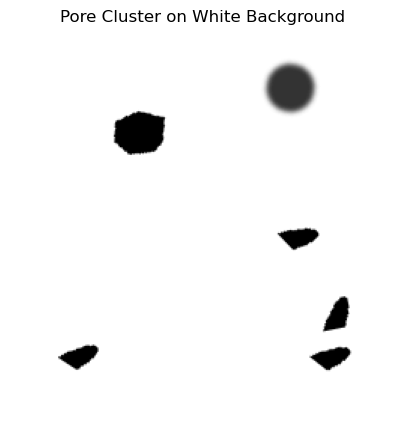

In [5]:
# Create a Python function to generate a cluster of the three selected pores
# and place them on a clean white background with optional random rotation and non-overlapping placement

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

def generate_pore(pore_type, size=64):
    """Generates an individual pore based on the selected type."""
    canvas = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)

    if pore_type == "veiled_void":
        cv2.circle(canvas, center, 16, 80, -1)
        canvas = cv2.GaussianBlur(canvas, (9, 9), 0)

    elif pore_type == "jagged_pit":
        pts = np.array([[20, 25], [26, 15], [38, 12], [48, 20],
                        [45, 36], [32, 48], [20, 38], [18, 30]])
        cv2.fillPoly(canvas, [pts], 100)

    elif pore_type == "half_vertical":
        cv2.ellipse(canvas, center, (22, 6), 30, 0, 360, 100, -1)
        canvas[:, :center[0]] = 0

    return canvas

def place_pore_cluster(
    image_size=256,
    pore_types=["veiled_void", "jagged_pit", "half_vertical"],
    num_pores=5,
    seed=None
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    bg = np.ones((image_size, image_size), dtype=np.uint8) * 255
    mask = np.zeros_like(bg)
    placed_regions = []

    for _ in range(num_pores):
        attempts = 0
        while attempts < 100:
            pore_type = random.choice(pore_types)
            pore = generate_pore(pore_type)
            angle = random.randint(0, 360)

            # Rotate pore
            M = cv2.getRotationMatrix2D((32, 32), angle, 1)
            rotated = cv2.warpAffine(pore, M, (64, 64))

            x = random.randint(0, image_size - 64)
            y = random.randint(0, image_size - 64)
            region = mask[y:y+64, x:x+64]
            if np.any(cv2.bitwise_and(region, rotated)):
                attempts += 1
                continue

            # Blend onto background
            sub_img = bg[y:y+64, x:x+64]
            combined = cv2.subtract(sub_img, rotated)
            bg[y:y+64, x:x+64] = combined
            mask[y:y+64, x:x+64] = cv2.bitwise_or(mask[y:y+64, x:x+64], rotated)
            placed_regions.append((x, y))
            break

    return bg

# Generate and show an example
example_cluster = place_pore_cluster(num_pores=6, seed=42)
plt.figure(figsize=(5, 5))
plt.imshow(example_cluster, cmap='gray')
plt.title("Pore Cluster on White Background")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# -------- Custom Pore Shape --------
custom_pore_points = np.array([
    [110, 20], [85, 30], [65, 50], [55, 85], [65, 95],
    [100, 98], [110, 100], [155, 95], [165, 85], [155, 50],
    [135, 30], [110, 20]
], dtype=np.float32)
f = 0.20
custom_pore_points[5] = (1 - f) * custom_pore_points[5] + f * custom_pore_points[1]
custom_pore_points[6] = (1 - f) * custom_pore_points[6] + f * custom_pore_points[10]

def generate_custom_pore_shape(scale=1.0):
    pts = custom_pore_points * scale
    tck, _ = splprep(pts.T, s=0, per=True)
    u = np.linspace(0, 1.0, 500)
    curve = np.stack(splev(u, tck), axis=-1).astype(np.int32)
    return curve

# -------- Top-Light Shading Function --------
def render_top_light_shadow(canvas, shape, color_core=(30, 30, 30), rim_color=(255, 255, 255)):
    h, w = canvas.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [shape], 255)

    gradient = np.linspace(0, 1, h).reshape(h, 1)
    shadow = ((1 - gradient) * 100).astype(np.uint8)
    shadow = np.repeat(shadow, w, axis=1)
    shadow[mask == 0] = 0

    shaded = np.zeros((h, w, 4), dtype=np.uint8)
    for i in range(3): shaded[..., i] = color_core[i]
    shaded[..., 3] = shadow

    # Add sharp rim
    cv2.polylines(shaded, [shape], isClosed=True, color=(*rim_color, 255), thickness=2, lineType=cv2.LINE_AA)

    # Alpha blend with canvas
    alpha = shaded[..., 3] / 255.0
    result = canvas.copy()
    for c in range(3):
        result[..., c] = (alpha * shaded[..., c] + (1 - alpha) * result[..., c]).astype(np.uint8)
    return result

# -------- Main Visualization --------
def generate_single_top_light_pore(size=256):
    background = np.ones((size, size, 3), dtype=np.uint8) * 255  # white background
    shape = generate_custom_pore_shape(scale=0.4)
    shape[:, 0] += size // 2 - shape[:, 0].mean().astype(int)
    shape[:, 1] += size // 2 - shape[:, 1].mean().astype(int)
    result = render_top_light_shadow(background, shape)
    return result

# -------- Generate & Show --------
img = generate_single_top_light_pore()
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Single Pore with Top-Light Shadow (B.2)")
plt.axis('off')
plt.show()


✅ Saved: 0c9c31fa-8-44.1.jpg
